# To reproduce a run and investigate seasonal transition signature

In [1]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

sys.path.append("../libs/py_cfe")
from bmi_cfe import BMI_CFE

sys.path.append("../libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.getcwd()

'g:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\4_post_analysis'

# Configuration

In [49]:
study_site = "LittleWashita"
case = f"{study_site}-2023-08-20"
run_id = 0

In [50]:
data_directory = rf"..\data\{study_site}"
config_temp_path = os.path.join(data_directory, "temporary_parameter_files_for_GLUE", "config_cfe_0.json")
prior_params_path = rf"..\2_GLUE_prerun\results\{case}\prior_parameters.csv"
evaluation_metrics_path = rf"..\2_GLUE_prerun\results\{case}\evaluation_metrics.csv"
out_path = rf".\results\{case}"
if not os.path.exists(out_path):
    os.makedirs(out_path)

# Load parameters for a run

In [51]:
config_all_runs = pd.read_csv(prior_params_path)
config_target_runs = config_all_runs[config_all_runs["run_id"]==run_id]
print(config_target_runs)

   run_id        bb     satdk
0       0  6.869111  0.000048


In [52]:
with open(config_temp_path, 'r') as outfile:
    config_temp = json.load(outfile)

In [53]:
for key, value in config_target_runs.items():
    if key == "run_id":
        None
    elif key in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][key] = value.values[0]
    else:
        config_temp[key] = value.values[0]
config_temp

{'forcing_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/LittleWashita/little_washita_2006_2012.csv',
 'catchment_area_km2': 610,
 'soil_params': {'bb': 6.869110823731299,
  'satdk': 4.8132314610854966e-05,
  'slop': 0.02,
  'satpsi': 0.141,
  'smcmax': 0.4,
  'wltsmc': 0.05,
  'D': 2},
 'alpha_fc': 0.18,
 'max_gw_storage': 137,
 'Cgw': 1,
 'expon': 1.75,
 'lksatfac': 1000,
 'dd': 0.00146,
 'refkdt': 3,
 'K_nash': 0.03,
 'trigger_z_fact': 0.25,
 'nash_storage': [0.0, 0.0],
 'giuh_ordinates': [0.1, 0.4, 0.2, 0.2, 0.1],
 'stand_alone': 1,
 'unit_test': 1,
 'compare_results_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/LittleWashita/test_sm_basinavg.csv'}

In [54]:
temporary_config_path = "temporary_config_reproducing_run"
if not os.path.exists(temporary_config_path):
    os.makedirs(temporary_config_path)
    
temporary_config_file = os.path.join(temporary_config_path, f"config_cfe_{run_id}.json")
with open(temporary_config_file, 'w') as out_file:
    json.dump(config_temp, out_file)

# Run CFE

In [55]:
# Run the CFE based on the config file
cfe_instance = BMI_CFE(temporary_config_file)
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=False, warm_up=True)
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d %H:%M:%S")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
# obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d %H:%M:%S")  # works for Little ashita
# obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

obs_synced, sim_synced

(       Soil Moisture Content
 0                   0.179808
 1                   0.179020
 2                   0.178306
 3                   0.177500
 4                   0.176834
 ...                      ...
 52627               0.085587
 52628               0.085209
 52629               0.085148
 52630               0.085863
 52631               0.085651
 
 [52632 rows x 1 columns],
        Soil Moisture Content
 0                   0.133590
 1                   0.133559
 2                   0.133528
 3                   0.133497
 4                   0.133466
 ...                      ...
 52627               0.104387
 52628               0.104331
 52629               0.104276
 52630               0.104220
 52631               0.104165
 
 [52632 rows x 1 columns])

# Run seasonal signature

In [56]:
# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=obs_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="obs"
)

_t_valley_manual_input = pd.read_csv(
    os.path.join(data_directory, "seasonal_cycel_valleys.csv"), header=None
)
t_valley_manual_input = pd.to_datetime(_t_valley_manual_input[0])
season_trans_obs, start_dates_obs, end_dates_obs = sig_obs.calc_seasontrans(t_valley=t_valley_manual_input)

sig_sim = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=sim_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="sim"
)
season_trans_sim, start_dates_sim, end_dates_sim = sig_sim.calc_seasontrans(t_valley=t_valley_manual_input)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



[[140.49768401  62.49769656  38.99968905 173.02185928]
 [130.6224305  194.99997886  63.36948671 154.88899616]
 [ 16.00005182  54.75415466  66.66862695 201.75374372]
 [-62.96809109 -72.03521379  89.7144575  125.44738252]
 [136.16552896 303.69462717 129.9997961   28.8152528 ]
 [ 76.18441468 222.90610948  20.10338591 106.14433673]
 [         nan          nan          nan          nan]]
[ 72.75033648 127.80289216  68.1425737  131.6785952 ]


# Load evaluation metrics

In [57]:
result_run = pd.read_csv(evaluation_metrics_path)
KGESM_for_the_run = result_run['KGE on Soil'][result_run["run_id"]==run_id].values[0]
print(KGESM_for_the_run)
result_run.head()

0.1089715113843473


,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end
0,0,-4.089466,-1.278917,-0.532260,0.108972,72.750336,127.802892,68.142574,131.678595
1,1,-4.150685,-1.248777,-0.565483,0.138962,72.749544,124.187188,68.142112,130.489289
2,2,-4.104244,-1.241158,-0.548034,0.130574,76.382144,129.038721,68.146401,131.206043


# Plot the results

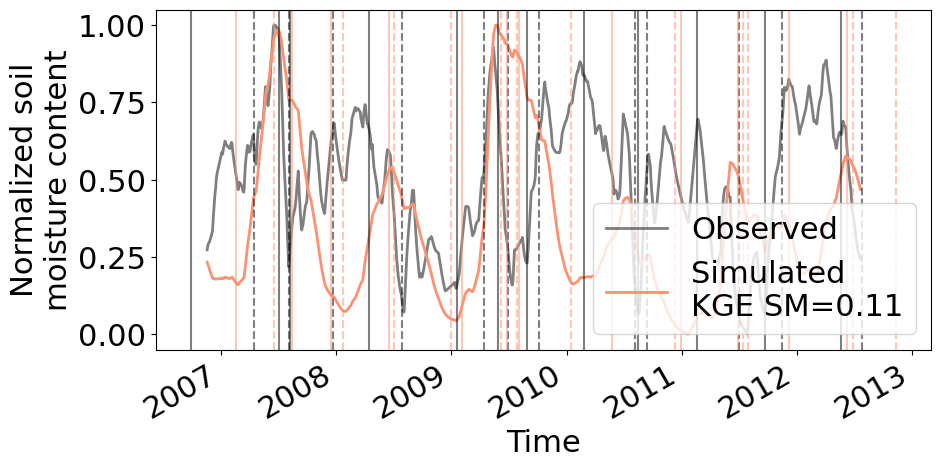

In [58]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(10, 5))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right')
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')